<a href="https://colab.research.google.com/github/T-Yamaguch/WGAN-gp/blob/master/WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Tue Oct  6 17:42:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    33W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Concatenate, Conv2D, \
MaxPooling2D, Activation, ReLU, LeakyReLU, UpSampling2D, BatchNormalization, \
Dropout, Dense, Flatten, Add, LayerNormalization, GaussianNoise, Reshape, Lambda
from keras.regularizers import l2

class up_block(Model):
  def __init__(self, filter_num, kernel_size, kernel_regularizer= l2(0.001)):
    super(up_block, self).__init__()
    self.conv = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.norm = BatchNormalization(trainable=True)
    self.act = LeakyReLU()
    self.up = UpSampling2D((2,2))
    self.noise = GaussianNoise(0.2)

  def call(self, x):
    x = self.conv(x)
    x = self.norm(x)
    x = self.act(x)
    x = self.up(x)
    x = self.noise(x)
    return x

class res_block(Model):
  def __init__(self, filter_num, kernel_size, kernel_regularizer= l2(0.001)):
    super(res_block, self).__init__()
    self.conv1 = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.conv2 = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.norm1 = BatchNormalization(trainable=True)
    self.norm2 = BatchNormalization(trainable=True)
    self.act1 = LeakyReLU()
    self.act2 = LeakyReLU()
    self.add = Add()

  def call(self, x):
    y = self.conv1(x)
    y = self.norm1(y)
    y = self.act1(y)
    y = self.conv2(y)
    y = self.norm2(y)
    y = self.act2(y)
    x = self.add([x, y])
    return x

class down_block(Model):
  def __init__(self, filter_num, kernel_size, kernel_regularizer= l2(0.001)):
    super(down_block, self).__init__()
    self.conv = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.norm = BatchNormalization(trainable=True)
    self.act = LeakyReLU()
    self.pooling = MaxPooling2D((2,2), strides=(2,2))
    self.drop = Dropout(0.3)

  def call(self, x):
    x = self.conv(x)
    x = self.norm(x)
    x = self.act(x)
    x = self.pooling(x)
    x = self.drop(x)
    return x

class conv_block(Model):
  def __init__(self, filter_num, kernel_size, kernel_regularizer= l2(0.001), batch_norm = True):
    super(conv_block, self).__init__()
    self.conv = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.norm = BatchNormalization(trainable=True)
    self.act = LeakyReLU()
    self.drop = Dropout(0.3)
    self.batch_norm = batch_norm

  def call(self, x):
    x = self.conv(x)
    if self.batch_norm == True:
      x = self.norm(x)
    x = self.act(x)
    x = self.drop(x)
    return x

class dense_block(Model):
  def __init__(self, filter_num, kernel_regularizer= l2(0.001), batch_norm = True):
    super(dense_block, self).__init__()
    self.dense = Dense(filter_num, kernel_regularizer= kernel_regularizer)
    self.norm = BatchNormalization(trainable=True)
    self.act = LeakyReLU()
    self.batch_norm = batch_norm

  def call(self, x):
    x = self.dense(x)
    if self.batch_norm == True:
      x = self.norm(x)
    x = self.act(x)
    return x


In [4]:
class Generator():
  def __init__(self):
    self.channel_num = 1024
    self.layer_num = 5
    self.res_num = 0
    self.latent_num = 8
    self.inputs = Input(shape=(self.latent_num)) 
    self.kernel_size = (5, 5)
    self.name = 'generator'
    self.kernel_regularizer= None
      
  def model(self):
    x = self.inputs

    final_size = 4*4*self.channel_num
    data_size = self.latent_num

    # while data_size*64 < final_size:
    #   data_size *= 64
    #   x = dense_block(data_size, kernel_regularizer= self.kernel_regularizer)(x)

    x = dense_block(final_size, kernel_regularizer= self.kernel_regularizer)(x)
    x = Reshape((4, 4, self.channel_num))(x)

    filter_num = self.channel_num
    
    for n in range(self.layer_num):
      for m in range(self.res_num):
        x = res_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
      # x = conv_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
      filter_num /= 2
      x = up_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)

    for m in range(self.res_num):
      x = res_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
    # x = conv_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)

    x = Conv2D(3, self.kernel_size, padding = 'same', kernel_regularizer= self.kernel_regularizer)(x)
    x = Activation('sigmoid')(x)
    outputs = x
    return Model(inputs = self.inputs, outputs = outputs, name = self.name)

g = Generator()
g.model().summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_block (dense_block)    (None, 16384)             212992    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 1024)        0         
_________________________________________________________________
up_block (up_block)          (None, 8, 8, 512)         13109760  
_________________________________________________________________
up_block_1 (up_block)        (None, 16, 16, 256)       3278080   
_________________________________________________________________
up_block_2 (up_block)        (None, 32, 32, 128)       819840    
_________________________________________________________________
up_block_3 (up_block)        (None, 64, 64, 64)        20

In [5]:
class Discriminator():
  def __init__(self):
    self.channel_num = 16
    self.layer_num = 5
    self.input_shape = (128, 128, 3)
    self.inputs = Input(shape=self.input_shape)
    self.kernel_size = (5, 5)
    self.name = 'discriminator'
    self.kernel_regularizer= None

  def model(self):
    x = self.inputs

    filter_num = self.channel_num
    for n in range(self.layer_num):
      # x = conv_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer, batch_norm = False)(x)
      x = down_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
      filter_num *= 2

    x = conv_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
    x = Flatten()(x)
    outputs =  Dense(1, kernel_regularizer= self.kernel_regularizer)(x)

    return Model(inputs = self.inputs, outputs = outputs, name = self.name)

d = Discriminator()
d.model().summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
down_block (down_block)      (None, 64, 64, 16)        1280      
_________________________________________________________________
down_block_1 (down_block)    (None, 32, 32, 32)        12960     
_________________________________________________________________
down_block_2 (down_block)    (None, 16, 16, 64)        51520     
_________________________________________________________________
down_block_3 (down_block)    (None, 8, 8, 128)         205440    
_________________________________________________________________
down_block_4 (down_block)    (None, 4, 4, 256)         820480    
_________________________________________________________________
conv_block (conv_block)      (None, 4, 4, 512)       


epochs 1
steps16
d loss: 8.3337, g loss: 0.0240
epoch time: 21.2285 [sec]

epochs 2
steps16
d loss: 6.9429, g loss: 0.1026
epoch time: 15.6965 [sec]

epochs 3
steps16
d loss: 5.1705, g loss: 0.1547
epoch time: 15.4730 [sec]

epochs 4
steps16
d loss: 3.2728, g loss: 0.1800
epoch time: 15.3452 [sec]

epochs 5
steps16
d loss: 1.0645, g loss: 0.1751
epoch time: 15.3342 [sec]

epochs 6
steps16
d loss: -1.2536, g loss: 0.1327
epoch time: 15.3714 [sec]

epochs 7
steps16
d loss: -3.7248, g loss: 0.0480
epoch time: 15.4351 [sec]

epochs 8
steps16
d loss: -6.3434, g loss: -0.0980
epoch time: 15.4266 [sec]

epochs 9
steps16
d loss: -8.8071, g loss: -0.3289
epoch time: 15.3798 [sec]

epochs 10
steps16
d loss: -11.0115, g loss: -0.6608
epoch time: 15.3539 [sec]


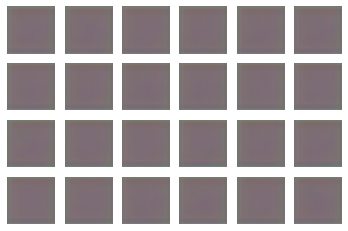

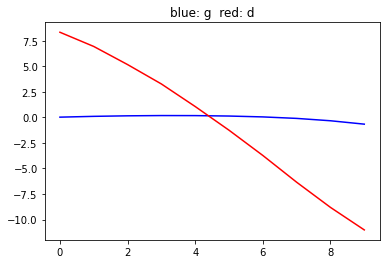


epochs 11
steps16
d loss: -12.6624, g loss: -1.1349
epoch time: 15.3629 [sec]

epochs 12
steps16
d loss: -13.6532, g loss: -1.7612
epoch time: 15.3918 [sec]

epochs 13
steps2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import binary_crossentropy, MSE
import glob
import time
import random
import sys

class WGAN():
  def __init__(self, 
               img_size= 128, 
               code_num = 2048,
               batch_size = 16, 
               train_epochs = 100, 
               train_steps = 8, 
               checkpoint_epochs = 25, 
               image_epochs = 1, 
               start_epoch = 1,
               optimizer = Adam(learning_rate = 1e-4),
               n_critics = 8,
               gp_lamda = 0.1
               ):
    
    self.batch_size = batch_size
    self.train_epochs =  train_epochs
    self.train_steps = train_steps
    self.checkpoint_epochs = checkpoint_epochs
    self.image_epochs = image_epochs
    self.start_epoch = start_epoch
    self.code_num = code_num
    self.img_size = img_size
    self.n_critics = n_critics
    self.gp_lamda = gp_lamda
    
    self.gen_optimizer = optimizer
    self.disc_optimizer = optimizer

    g = Generator()
    self.gen = g.model()
    
    d = Discriminator()
    self.disc = d.model()

    checkpoint_dir = "drive/My Drive/WGAN-gp/checkpoint"
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(gen_optimizer = self.gen_optimizer,
                                     disc_optimizer = self.disc_optimizer,
                                     gen = self.gen,
                                     disc = self.disc,
                                     )

    self.manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=2)

    train_image_path = 'drive/My Drive/samples/image'
    
    self.train_filenames = glob.glob(train_image_path + '/*.jpg') 

    checkpoint.restore(self.manager.latest_checkpoint)

    self.g_history = []
    self.d_history = []
    # self.endec_history = []  

  def preprocess_image(self, image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [self.img_size, self.img_size] )
    image = image/255  # normalize to [0,1] range
    return tf.cast(image, tf.float32)

  def load_and_preprocess_image(self, path):
    image = tf.io.read_file(path)
    return self.preprocess_image(image)

  def dataset(self, paths, batch_size):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    img_ds = path_ds.map(self.load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    img_ds = img_ds.batch(batch_size)
    return img_ds

  def image_preparation(self, filenames, batch_size, steps):
    img_batch = []
    while 1:
      random.shuffle(filenames)
      for path in filenames:
        img_batch.append(path)
        if len(img_batch) == steps*batch_size:
          imgs = self.dataset(img_batch, batch_size)
          img_batch = []
          yield imgs

  def discriminator_loss(self, original_outputs, generated_outputs):
    real_loss = binary_crossentropy(tf.ones_like(original_outputs), original_outputs)
    generated_loss = binary_crossentropy(tf.zeros_like(generated_outputs), generated_outputs)
    loss_d = tf.math.reduce_mean(real_loss + generated_loss)
    return loss_d

  def generator_loss(self, generated_outputs):
    loss_g = tf.math.reduce_mean(binary_crossentropy(tf.ones_like(generated_outputs), generated_outputs))
    return loss_g

  def mse_loss(self, true, pred):
    loss =  tf.math.reduce_mean(MSE(true, pred))
    return loss

  def wasserstein_loss(self, ori_outputs, gen_outputs):
    d_loss = -tf.reduce_mean(ori_outputs) + tf.reduce_mean(gen_outputs)
    g_loss = -tf.reduce_mean(gen_outputs)
    return d_loss, g_loss

  def w_gp_loss(self, ori_outputs, gen_outputs, imgs, gen_imgs):
    d_loss = -tf.reduce_mean(ori_outputs) + tf.reduce_mean(gen_outputs)
    g_loss = -tf.reduce_mean(gen_outputs)

    alpha = tf.random.uniform(shape=[self.batch_size, 1, 1, 1], minval=0, maxval=1, dtype=tf.dtypes.float32)
    inter_sample = alpha * imgs + (1-alpha) * gen_imgs
    with tf.GradientTape() as tape_gp:
      tape_gp.watch(inter_sample)
      inter_score = self.disc(inter_sample)
    gp_gradients = tape_gp.gradient(inter_score, inter_sample)
    gp_gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gp_gradients), axis = [1, 2, 3]))
    gp = tf.reduce_mean((gp_gradients_norm - 1.0) ** 2)

    d_loss += gp * self.gp_lamda
    
    return d_loss, g_loss


  def g_train(self, imgs):
    noise =tf.random.uniform([self.batch_size, self.code_num], minval=0, maxval=1, dtype=tf.dtypes.float32)

    with tf.GradientTape() as gen_tape:
      gen_imgs = self.gen(noise, training=True)

      ori_outputs = self.disc(imgs, training=False)
      gen_outputs = self.disc(gen_imgs, training=False)

      _, g_loss = self.w_gp_loss(ori_outputs, gen_outputs, imgs, gen_imgs)
      self.g_temp.append(g_loss)

    gradients_of_gen = gen_tape.gradient(g_loss, self.gen.trainable_variables)
    self.gen_optimizer.apply_gradients(zip(gradients_of_gen, self.gen.trainable_variables))

  def d_train(self, imgs):
    noise =tf.random.uniform([self.batch_size, self.code_num], minval=0, maxval=1, dtype=tf.dtypes.float32)

    with tf.GradientTape() as disc_tape:
      gen_imgs = self.gen(noise, training=False)

      ori_outputs = self.disc(imgs, training=True)
      gen_outputs = self.disc(gen_imgs, training=True)
      
      d_loss, _ = self.w_gp_loss(ori_outputs, gen_outputs, imgs, gen_imgs)
      self.d_temp.append(d_loss)

    gradients_of_disc = disc_tape.gradient(d_loss, self.disc.trainable_variables)    
    self.disc_optimizer.apply_gradients(zip(gradients_of_disc, self.disc.trainable_variables))

  def visualise_batch(self, s_1, epoch):
    gen_img = self.gen(s_1)  
    gen_img = (np.array(gen_img*255, np.uint8))
    fig, axes = plt.subplots(4, 6)
    for idx, img in enumerate(gen_img):
      p, q = idx//6, idx%6
      axes[p, q].imshow(img)
      axes[p, q].axis('off')
    
    save_name = 'drive/My Drive/WGAN-gp/generated_image/'+'image_at_epoch_{:04d}.png'
    plt.savefig(save_name.format(epoch), dpi=200)
    plt.pause(0.1)
    plt.close('all')

  def loss_vis(self):
    plt.plot(self.g_history, 'b', self.d_history, 'r')
    plt.title('blue: g  red: d')
    plt.savefig('drive/My Drive/WGAN-gp/loss/gan_loss.png')
    plt.pause(0.1)
    plt.close('all')

  def update_loss_history(self):
    d_batch_loss = sum(self.d_temp)/len(self.d_temp)
    g_batch_loss = sum(self.g_temp)/len(self.g_temp)
    print ('\nd loss: {:.4f}, g loss: {:.4f}'.format(d_batch_loss, g_batch_loss))
    self.d_history.append(d_batch_loss)
    self.g_history.append(g_batch_loss)
    self.d_temp = []
    self.g_temp = []

  def __call__(self):
    sample_noise =tf.random.uniform([24, self.code_num], minval=0, maxval=1, dtype=tf.dtypes.float32)
    image_loader = self.image_preparation(self.train_filenames, self.batch_size, self.train_steps)
    self.d_temp = []
    self.g_temp = []

    for epoch in range(self.start_epoch, self.train_epochs+1):
      
      start_time = time.time()

      print ('\nepochs {}'.format(epoch))
      imgs_ds = next(image_loader)

      for steps, imgs in enumerate(imgs_ds):
        print("\r" + 'steps{}'.format(steps+1), end="")
        sys.stdout.flush()

        self.d_train(imgs)

        if steps % self.n_critics == 0:
          self.g_train(imgs)
        
      self.update_loss_history()

      epoch_time = time.time() - start_time
      print ("epoch time: {:.4f} [sec]".format(epoch_time))
                               
      if epoch % self.image_epochs == 0:
        self.visualise_batch(sample_noise, epoch)
        self.loss_vis()

      if epoch % self.checkpoint_epochs == 0:
        print ('\nSaving checkpoint at epoch{}\n\n'.format(epoch))
        self.manager.save()
      
if __name__ == '__main__':
  a = WGAN(img_size = 128,
           code_num = 8,
           batch_size = 128,
           train_epochs = 10000, 
           train_steps = 16, 
           checkpoint_epochs = 100, 
           image_epochs = 10, 
           start_epoch = 1,
           optimizer = Adam(learning_rate = 1e-6),
           n_critics = 2,
           gp_lamda = 10
           )
  a()